In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [26]:
def json_to_df(path_or_obj):
    # Accept either a filepath (str) or already-loaded Python dict
    if isinstance(path_or_obj, str):
        with open(path_or_obj, "r", encoding="utf-8") as f:
            data = json.load(f)
    else:
        data = path_or_obj

    rows = []
    for date_str, payload in data.items():
        results = (payload or {}).get("results", {}) or {}
        for industry, info in results.items():
            rows.append({
                "date": pd.to_datetime(date_str, format="%Y%m%d", errors="coerce"),
                "industry": industry,
                "score": (info or {}).get("score")
            })

    df = pd.DataFrame(rows, columns=["date", "industry", "score"])
    df = df.dropna(subset=["date"]).sort_values(["date", "industry"]).reset_index(drop=True)
    return df

sentiments = json_to_df("/Users/edwardju/Downloads/chinese-stock-market/data/industry_sentiment.json")
tot = sentiments.groupby("date")["score"].transform(lambda s: s.abs().sum())
sentiments["tot_score"] = tot
sentiments["norm_score"] = sentiments["score"].div(tot).where(tot.ne(0))
sentiments.head()

,date,industry,score,tot_score,norm_score
0,2015-01-01,Agriculture,30,280,0.107143
1,2015-01-01,Air Transport,0,280,0.000000
2,2015-01-01,Animal Husbandry,10,280,0.035714
3,2015-01-01,Art Industry,20,280,0.071429
4,2015-01-01,Banking,0,280,0.000000


In [27]:
mean_scores = pd.DataFrame(sentiments.groupby('industry')['score'].mean().sort_values(ascending=False))
mean_scores[mean_scores.index.str.contains('Art')]

,score
industry,
Art Industry,10.01391


In [28]:
d = sentiments["date"]
s = sentiments["score"].astype(float)

n = s.groupby(d).transform("size")
k = np.ceil(0.1 * n).astype(int)

neg = s.groupby(d).rank(method="first", ascending=True) <= k
pos = s.groupby(d).rank(method="first", ascending=False) <= k

pos_den = s.where(pos, 0).groupby(d).transform("sum")
neg_den_abs = s.abs().where(neg, 0).groupby(d).transform("sum")
neg_cnt = neg.groupby(d).transform("sum")

sentiments["tail_norm"] = 0.0

# Normal: positives sum to +1 (when pos_den != 0)
pos_ok = pos & pos_den.ne(0) & s.notna()
sentiments.loc[pos_ok, "tail_norm"] = s[pos_ok] / pos_den[pos_ok]

# Normal: negatives sum to -1 via abs-weight (when neg_den_abs != 0)
neg_ok = neg & neg_den_abs.ne(0) & s.notna()
sentiments.loc[neg_ok, "tail_norm"] = -s.abs()[neg_ok] / neg_den_abs[neg_ok]

# Fallback: if selected negatives are all 0, split -1 equally across them
neg_fb = neg & neg_den_abs.eq(0) & neg_cnt.gt(0)
sentiments.loc[neg_fb, "tail_norm"] = -1.0 / neg_cnt[neg_fb]
sentiments.head()

,date,industry,score,tot_score,norm_score,tail_norm
0,2015-01-01,Agriculture,30,280,0.107143,0.150
1,2015-01-01,Air Transport,0,280,0.000000,-0.125
2,2015-01-01,Animal Husbandry,10,280,0.035714,0.000
3,2015-01-01,Art Industry,20,280,0.071429,0.100
4,2015-01-01,Banking,0,280,0.000000,-0.125


In [29]:
check = sentiments.groupby("date")["norm_score"].agg(
    pos_sum=lambda x: x[x>0].sum(),
    neg_sum=lambda x: x[x<0].sum()
)
print(check.mean())

pos_sum    0.965032
neg_sum   -0.034968
dtype: float64


In [30]:
# def add_exp_decay_sentiment(df, col="score", id_col="industry", date_col="date",
#                             half_life_days=5):
#     d = df.copy()
#     d[date_col] = pd.to_datetime(d[date_col])
#     d = d.sort_values([id_col, date_col])

#     # Half-life -> span for pandas EWM (exponentially weighted moving)
#     alpha = 1 - np.exp(np.log(0.5) / half_life_days)      # daily decay rate
#     span = (2 / alpha) - 1                                # convert alpha <-> span

#     d["sent_ewma"] = (
#         d.groupby(id_col, group_keys=False)[col]
#          .apply(lambda s: s.ewm(span=span, adjust=False, min_periods=1).mean())
#     )

#     # Optional: lag so you only use info available before trading the day
#     d["sent_ewma_lag1"] = d.groupby(id_col)["sent_ewma"].shift(1)
    
#     s = d["sent_ewma_lag1"]
#     s = s - s.groupby(d["date"]).transform("mean")  # de-mean per day
#     abs_sum = s.abs().groupby(d["date"]).transform("sum")
#     d["w_ls"] = s / abs_sum
#     return d

# sentiments_decay = add_exp_decay_sentiment(sentiments, col='tail_norm', id_col='industry', half_life_days=5)
# sentiments_decay.head()

# Raw sentiment weights (no EWMA)
def add_raw_sentiment_weights(df, col="score", date_col="date"):
    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col])
    
    # weight = score / sum(abs(scores)) per day
    abs_sum = d.groupby(date_col)[col].transform(lambda x: x.abs().sum())
    d["w_ls"] = d[col] / abs_sum
    return d

sentiments_decay = add_raw_sentiment_weights(sentiments, col='score')
sentiments_decay.head()

,date,industry,score,tot_score,norm_score,tail_norm,w_ls
0,2015-01-01,Agriculture,30,280,0.107143,0.150,0.107143
1,2015-01-01,Air Transport,0,280,0.000000,-0.125,0.000000
2,2015-01-01,Animal Husbandry,10,280,0.035714,0.000,0.035714
3,2015-01-01,Art Industry,20,280,0.071429,0.100,0.071429
4,2015-01-01,Banking,0,280,0.000000,-0.125,0.000000


In [31]:
check = sentiments_decay.groupby("date")["w_ls"].agg(
    pos_sum=lambda x: x[x>0].sum(),
    neg_sum=lambda x: x[x<0].sum()
)
print(check.mean())


pos_sum    0.965032
neg_sum   -0.034968
dtype: float64


In [32]:
normal_sentiments = sentiments[['date', 'industry', 'norm_score']]
tail_sentiments = sentiments[['date', 'industry', 'tail_norm']]
tail_sentiments[['tail_norm']] /= 2
tail_sentiments["tail_norm_trailing"] = (
    tail_sentiments.groupby("industry")["tail_norm"]
    .transform(lambda s: s.rolling(30).mean().shift(1))
)
tail_sentiments = tail_sentiments.dropna(subset=["tail_norm_trailing"]).copy()
tail_sentiments.head()

/var/folders/cm/n391pt213xv2t590fn6lcrph0000gn/T/ipykernel_98259/2417577494.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tail_sentiments[['tail_norm']] /= 2
/var/folders/cm/n391pt213xv2t590fn6lcrph0000gn/T/ipykernel_98259/2417577494.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tail_sentiments["tail_norm_trailing"] = (


,date,industry,tail_norm,tail_norm_trailing
2130,2015-01-31,Agriculture,0.058824,0.057256
2131,2015-01-31,Air Transport,-0.200000,-0.027317
2132,2015-01-31,Animal Husbandry,-0.000000,-0.026080
2133,2015-01-31,Art Industry,0.000000,0.026923
2134,2015-01-31,Banking,-0.000000,0.004765


In [33]:
# Load with open and close prices for intraday calculation
daily_rets = pd.read_csv("/Users/edwardju/Downloads/CSMAR Daily Stock Return/TRD_Daily_full_20010101_20231201.csv",
                         usecols=['Stkcd', 'Trddt', 'Dsmvtll', 'Dretwd', 'Opnprc', 'Clsprc'])

# Rename columns properly (usecols doesn't preserve order, so use dict)
daily_rets = daily_rets.rename(columns={
    'Stkcd': 'stockid',
    'Trddt': 'date', 
    'Dsmvtll': 'tot_mv',
    'Dretwd': 'returns',
    'Opnprc': 'open',
    'Clsprc': 'close'
})
daily_rets['date'] = pd.to_datetime(daily_rets['date'], format='%Y-%m-%d')

# Calculate intraday return = (close - open) / open
daily_rets['intraday_ret'] = (daily_rets['close'] - daily_rets['open']) / daily_rets['open']

daily_rets.head()

,stockid,date,open,close,tot_mv,returns,intraday_ret
0,1,2016-01-04,12.00,11.33,1.621173e+08,-0.055046,-0.055833
1,1,2016-01-05,11.27,11.40,1.631189e+08,0.006178,0.011535
2,1,2016-01-06,11.42,11.53,1.649790e+08,0.011404,0.009632
3,1,2016-01-07,11.41,10.94,1.565369e+08,-0.051171,-0.041192
4,1,2016-01-08,11.21,11.12,1.591125e+08,0.016453,-0.008029


In [34]:
co_ind = pd.read_csv("/Users/edwardju/Downloads/CSMAR Daily Stock Return/TRD_Co.csv", encoding='cp1252', usecols=['Stkcd', 'Nindnme_en'])
co_ind.columns=['stockid', 'industry']
daily_rets = daily_rets.merge(co_ind, on=['stockid'], how='left')
daily_rets.head()

,stockid,date,open,close,tot_mv,returns,intraday_ret,industry
0,1,2016-01-04,12.00,11.33,1.621173e+08,-0.055046,-0.055833,Banking
1,1,2016-01-05,11.27,11.40,1.631189e+08,0.006178,0.011535,Banking
2,1,2016-01-06,11.42,11.53,1.649790e+08,0.011404,0.009632,Banking
3,1,2016-01-07,11.41,10.94,1.565369e+08,-0.051171,-0.041192,Banking
4,1,2016-01-08,11.21,11.12,1.591125e+08,0.016453,-0.008029,Banking


In [35]:
def keep_top_quartile_mv_by_industry(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d["date"] = pd.to_datetime(d["date"])
    d = d.dropna(subset=["stockid", "date", "tot_mv", "industry"])
    d = d.sort_values(["date", "industry", "stockid"])

    # within each (date, industry), keep stocks with MV >= 75th percentile
    q75 = d.groupby(["date", "industry"])["tot_mv"].transform(lambda s: s.quantile(0.90))
    return d[d["tot_mv"] >= q75].reset_index(drop=True)

# usage
daily_rets = keep_top_quartile_mv_by_industry(daily_rets)


In [36]:
def make_industry_portfolios(df):
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])

    df["tot_mv"] = pd.to_numeric(df["tot_mv"], errors="coerce")
    df["returns"] = pd.to_numeric(df["returns"], errors="coerce")
    df["intraday_ret"] = pd.to_numeric(df["intraday_ret"], errors="coerce")

    df["mv_x_ret"] = df["tot_mv"] * df["returns"]
    df["mv_x_intraday"] = df["tot_mv"] * df["intraday_ret"]

    out = (df.groupby(["date", "industry"], as_index=False)
            .agg(industry_tot_mv=("tot_mv", "sum"),
                mv_x_ret=("mv_x_ret", "sum"),
                mv_x_intraday=("mv_x_intraday", "sum")))

    # value-weighted industry return (close-to-close)
    out["industry_ret"] = out["mv_x_ret"].div(out["industry_tot_mv"]).where(out["industry_tot_mv"].ne(0))
    
    # value-weighted industry intraday return (open-to-close)
    out["industry_intraday"] = out["mv_x_intraday"].div(out["industry_tot_mv"]).where(out["industry_tot_mv"].ne(0))

    out = out[["date", "industry", "industry_ret", "industry_intraday", "industry_tot_mv"]].sort_values(["date", "industry"])
    return out

indus_portfolios = make_industry_portfolios(daily_rets)
indus_portfolios.head()

,date,industry,industry_ret,industry_intraday,industry_tot_mv
0,2001-01-02,Agriculture,0.019446,0.001157,7716478.51
1,2001-01-02,Air Transport,0.016071,0.016071,18777000.00
2,2001-01-02,Animal Husbandry,0.004651,0.004651,4209874.56
3,2001-01-02,Art Industry,0.015674,0.012500,2247264.00
4,2001-01-02,Banking,0.008193,0.008193,50417200.00


In [37]:
indus_portfolios[indus_portfolios['date'] >= pd.to_datetime('2015-01-01')].groupby('industry')['industry_ret'].mean().sort_values()

industry
Forestry                                                                -0.000133
Rental and Leasing Services                                             -0.000071
Oil and Gas Extraction                                                   0.000087
Warehousing                                                              0.000117
Railroad Transport                                                       0.000200
                                                                           ...   
Animal Husbandry                                                         0.002083
Furs, Leather, Feather and Related Products Manufacturing                0.002107
Computer Application Service                                             0.002122
Instruments and Apparatus, Culture and Office Machinery Manufacturing    0.002272
Nonmetallic Mineral Mining and Quarrying                                 0.002450
Name: industry_ret, Length: 71, dtype: float64

In [38]:
# import statsmodels.api as sm

# indus_ret_senti = pd.merge(indus_portfolios, sentiments_decay, on=['date', 'industry'], how='inner')
# # df columns needed: date, industry, industry_ret (today), sent_ewma (today's signal)
# d = indus_ret_senti.copy()
# d["date"] = pd.to_datetime(d["date"])
# d = d.sort_values(["industry","date"])

# # X = yesterday sentiment, y = tomorrow return
# d["sent_lag1"] = d.groupby("industry")["sent_ewma"].shift(1)
# # d["ret"]  = d.groupby("industry")["industry_ret"].shift(-1)
# d = d.dropna(subset=["sent_lag1","industry_ret"])

# # --- Option A: pooled OLS with standard errors clustered by date ---
# X = sm.add_constant(d["sent_lag1"])
# m = sm.OLS(d["industry_ret"], X).fit(cov_type="cluster", cov_kwds={"groups": d["date"]})
# print(m.summary())

import statsmodels.api as sm

indus_ret_senti = pd.merge(indus_portfolios, sentiments_decay, on=['date', 'industry'], how='inner')
d = indus_ret_senti.copy()
d["date"] = pd.to_datetime(d["date"])
d = d.sort_values(["industry","date"])

# X = yesterday sentiment (raw score), y = today's return
d["score_lag1"] = d.groupby("industry")["score"].shift(1)
d = d.dropna(subset=["score_lag1","industry_ret"])

X = sm.add_constant(d["score_lag1"])
m = sm.OLS(d["industry_ret"], X).fit(cov_type="cluster", cov_kwds={"groups": d["date"]})
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:           industry_ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                    0.3917
Date:                Wed, 10 Dec 2025   Prob (F-statistic):              0.531
Time:                        23:49:32   Log-Likelihood:             3.4087e+05
No. Observations:              153212   AIC:                        -6.817e+05
Df Residuals:                  153210   BIC:                        -6.817e+05
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.714      0.0

Normal Strategy Sharpe: 1.7054171143264465


/var/folders/cm/n391pt213xv2t590fn6lcrph0000gn/T/ipykernel_98259/3475729827.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sw_ret_normal = d.groupby("date").apply(lambda g: (g[w_name] * g["next_day_intraday"]).sum()).rename("sw_ret")


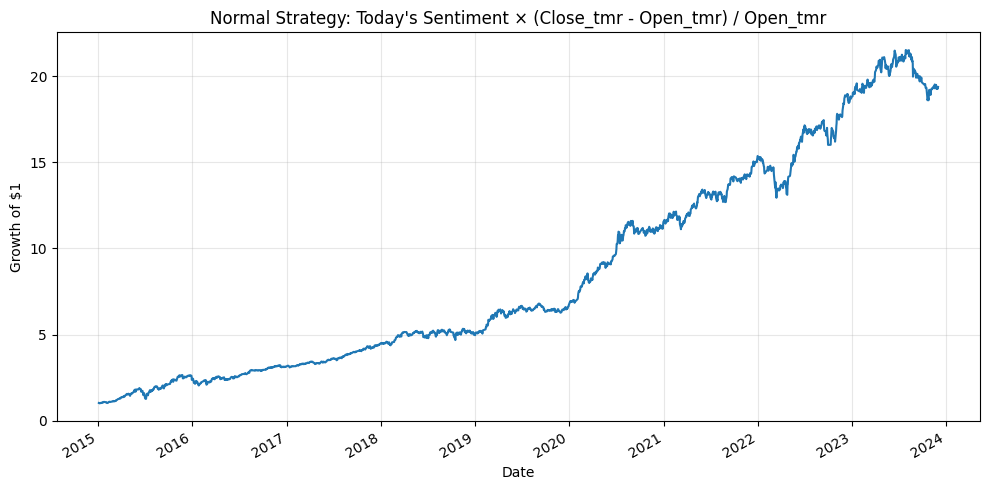

In [ ]:
# today's sentiment × (close_tmr - open_tmr) / open_tmr

d = indus_ret_senti.copy().sort_values(['industry', 'date'])
d['next_day_intraday'] = d.groupby('industry')['industry_intraday'].shift(-1)
d = d.dropna(subset=['next_day_intraday', 'w_ls'])

w_name = 'w_ls'
sw_ret_normal = d.groupby("date").apply(lambda g: (g[w_name] * g["next_day_intraday"]).sum()).rename("sw_ret")
sw_ret_normal = sw_ret_normal.sort_index()
cum_normal = (1.0 + sw_ret_normal).cumprod().rename("cum_growth")
print("Normal Strategy Sharpe:", sw_ret_normal.mean() / sw_ret_normal.std() * np.sqrt(243))

ax = cum_normal.plot(figsize=(10, 5))
ax.set_title("Normal Strategy: Today's Sentiment × (Close_tmr - Open_tmr) / Open_tmr")
ax.set_xlabel("Date")
ax.set_ylabel("Growth of $1")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Overnight Strategy Sharpe: 0.946636440807438


/var/folders/cm/n391pt213xv2t590fn6lcrph0000gn/T/ipykernel_98259/199938317.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sw_ret_overnight = d.groupby("date").apply(lambda g: (g[w_name] * g["next_day_ret"]).sum()).rename("sw_ret")


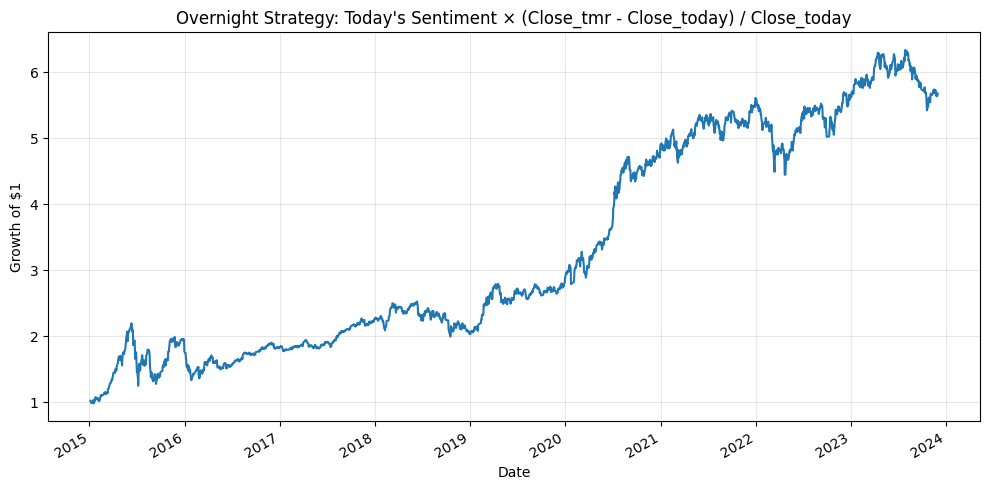

In [ ]:
# today's sentiment × (close_tmr - close_today) / close_today

d = indus_ret_senti.copy().sort_values(['industry', 'date'])
d['next_day_ret'] = d.groupby('industry')['industry_ret'].shift(-1)
d = d.dropna(subset=['next_day_ret', 'w_ls'])

w_name = 'w_ls'
sw_ret_overnight = d.groupby("date").apply(lambda g: (g[w_name] * g["next_day_ret"]).sum()).rename("sw_ret")
sw_ret_overnight = sw_ret_overnight.sort_index()
cum_overnight = (1.0 + sw_ret_overnight).cumprod().rename("cum_growth")
print("Overnight Strategy Sharpe:", sw_ret_overnight.mean() / sw_ret_overnight.std() * np.sqrt(243))

ax = cum_overnight.plot(figsize=(10, 5))
ax.set_title("Overnight Strategy: Today's Sentiment × (Close_tmr - Close_today) / Close_today")
ax.set_xlabel("Date")
ax.set_ylabel("Growth of $1")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Baseline Sharpe: 0.9417088402743704


/var/folders/cm/n391pt213xv2t590fn6lcrph0000gn/T/ipykernel_98259/502102104.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  baseline_ret = d.groupby("date").apply(lambda g: (g["w"] * g["industry_ret"]).sum()).rename("baseline_ret")


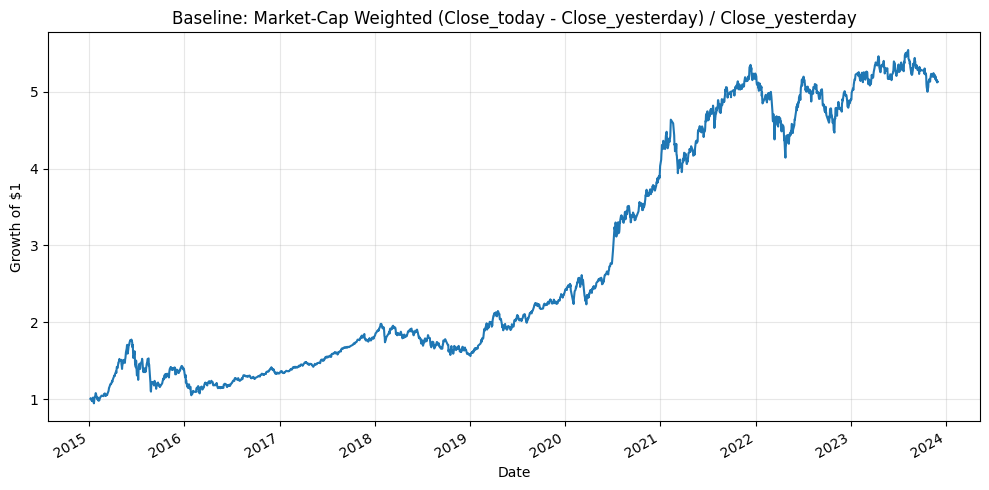

In [ ]:
# baseline: Market-cap weighted (close_today - close_yesterday) / close_yesterday

d = indus_ret_senti.copy()
d = d.sort_values(["industry", "date"])
d["prev_mv"] = d.groupby("industry")["industry_tot_mv"].shift(1)
d = d.dropna(subset=["prev_mv"])
d = d[d["prev_mv"] > 0]

d["day_mv"] = d.groupby("date")["prev_mv"].transform("sum")
d = d[d["day_mv"] > 0]
d["w"] = d["prev_mv"] / d["day_mv"]

baseline_ret = d.groupby("date").apply(lambda g: (g["w"] * g["industry_ret"]).sum()).rename("baseline_ret")
baseline_ret = baseline_ret.sort_index()
cum_baseline = (1.0 + baseline_ret).cumprod().rename("cum_growth")
print("Baseline Sharpe:", baseline_ret.mean() / baseline_ret.std() * np.sqrt(243))

ax = cum_baseline.plot(figsize=(10, 5))
ax.set_title("Baseline: Market-Cap Weighted (Close_today - Close_yesterday) / Close_yesterday")
ax.set_xlabel("Date")
ax.set_ylabel("Growth of $1")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()